In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from distutils.dir_util import copy_tree, remove_tree
from PIL import Image
from random import randint
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow_addons as tfa
from keras.utils import plot_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
import cv2
import keras

In [4]:
base='./data2/'
# root_dir='./'
test=base+"test/"
train=base+"train/"
wdr="./dataset4/"
# if os.path.exists(wdr):
#     remove_tree(wdr)
# os.mkdir(wdr)
# copy_tree(train,wdr)
# copy_tree(test,wdr)
print("wdc:",os.listdir(wdr))

wdc: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [5]:
work='./dataset4/'
classes=['glioma', 'meningioma', 'notumor', 'pituitary']
idm=176
ida=[176,208]
DIM=(idm,idm)

In [6]:
train_data_gen=IDG(rescale=1./255)
train_data_gen=train_data_gen.flow_from_directory(directory=work,target_size=DIM,batch_size=10185)

Found 10185 images belonging to 4 classes.


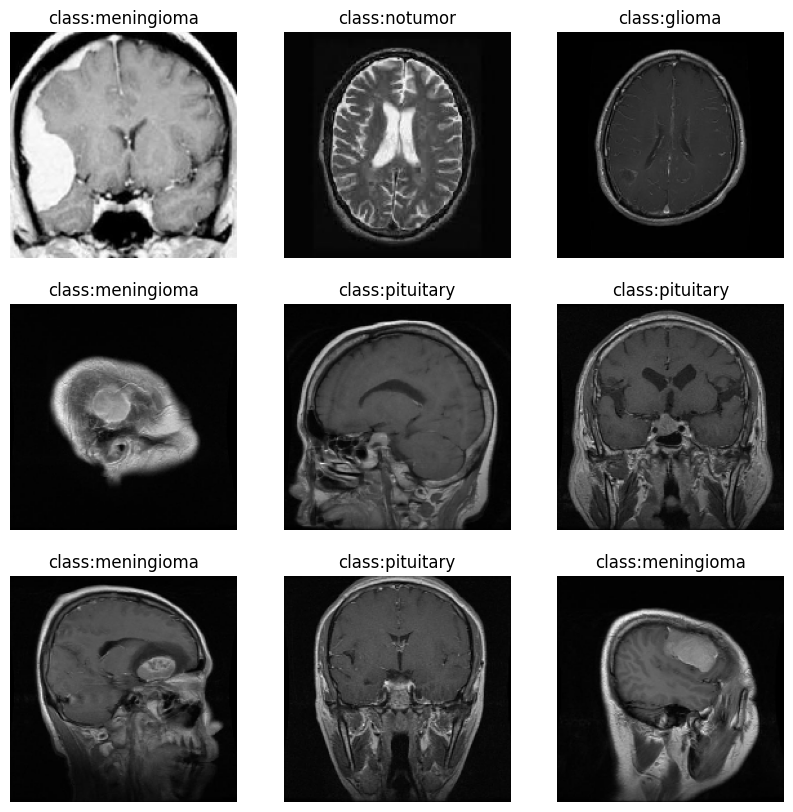

In [7]:
def show_images(generator):
    labels=dict(zip([0,1,2,3],classes))
    x,y=generator.next()
    plt.figure(figsize=(10,10))
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        idx=randint(0,600)
        plt.imshow(x[idx])
        plt.axis("off")
        plt.title("class:{}".format(labels[np.argmax(y[idx])]))


show_images(train_data_gen)

In [8]:
train_data,train_labels=train_data_gen.next()

In [9]:
sm=SMOTE(random_state=42)
train_data,train_labels=sm.fit_resample(train_data.reshape(-1,idm*idm*3),train_labels)
train_data=train_data.reshape(-1,idm,idm,3)
print(train_data.shape,train_labels.shape)

(10636, 176, 176, 3) (10636, 4)


In [10]:
train_data,test_data,train_labels,test_labels=train_test_split(train_data,train_labels,test_size=0.2,random_state=42)
train_data,val_data,train_labels,val_labels=train_test_split(train_data,train_labels,test_size=0.2,random_state=42)

In [11]:
incmodel=InceptionV3(input_shape=(176,176,3),include_top=False,weights="imagenet")
for layer in incmodel.layers:
    layer.trainable=False
incmodel.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 176, 176, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 87, 87, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 87, 87, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 87, 87, 32)           0         ['batch_normalizati

In [12]:
custommodel=Sequential([incmodel,Dropout(0.5),
                            GlobalAveragePooling2D(),Flatten(),
                            BatchNormalization(),
                            Dense(512,activation='relu'),
                            BatchNormalization(),
                            Dropout(0.5),
                            Dense(256,activation='relu'),
                            BatchNormalization(),
                            Dropout(0.5),
                            Dense(128,activation='relu'),
                            BatchNormalization(),
                            Dropout(0.5),
                            Dense(64,activation='relu'),
                            BatchNormalization(),
                            Dropout(0.5),
                            Dense(4,activation='softmax'),
                            ],name="inception_cnn_model")

In [13]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('train_acc') > 0.99:
            print('\nreached accuracy threshold terminating training')
            self.model.stop_training=True
my_callback=MyCallback()
rop_callback=ReduceLROnPlateau(monitor="val_loss",patience=3)

In [14]:
METRICS=[tf.keras.metrics.CategoricalAccuracy(name='train_acc'),
         tf.keras.metrics.AUC(name='val_acc'),
         tfa.metrics.F1Score(num_classes=4)]
CALLBACKS=[my_callback,rop_callback]
custommodel.compile(loss=tf.losses.CategoricalCrossentropy(),metrics=METRICS)
custommodel.summary()


Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 4, 4, 2048)        0         
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense (Dense)               (None, 512)       

In [15]:
EPOCHS=10
history=custommodel.fit(train_data,train_labels,validation_data=(val_data,val_labels),epochs=EPOCHS)

Epoch 1/10
213/213 [==============================] - 93s 420ms/step - loss: 1.0104 - train_acc: 0.6202 - val_acc: 0.8534 - f1_score: 0.6130 - val_loss: 0.4294 - val_train_acc: 0.8361 - val_val_acc: 0.9683 - val_f1_score: 0.8376
Epoch 2/10
213/213 [==============================] - 93s 440ms/step - loss: 0.5515 - train_acc: 0.8056 - val_acc: 0.9492 - f1_score: 0.8042 - val_loss: 0.3519 - val_train_acc: 0.8749 - val_val_acc: 0.9784 - val_f1_score: 0.8758
Epoch 3/10
213/213 [==============================] - 95s 449ms/step - loss: 0.4290 - train_acc: 0.8537 - val_acc: 0.9678 - f1_score: 0.8532 - val_loss: 0.2543 - val_train_acc: 0.9031 - val_val_acc: 0.9865 - val_f1_score: 0.9043
Epoch 4/10
213/213 [==============================] - 97s 455ms/step - loss: 0.3599 - train_acc: 0.8810 - val_acc: 0.9758 - f1_score: 0.8799 - val_loss: 0.2214 - val_train_acc: 0.9195 - val_val_acc: 0.9907 - val_f1_score: 0.9208
Epoch 5/10
213/213 [==============================] - 96s 453ms/step - loss: 0.3139 

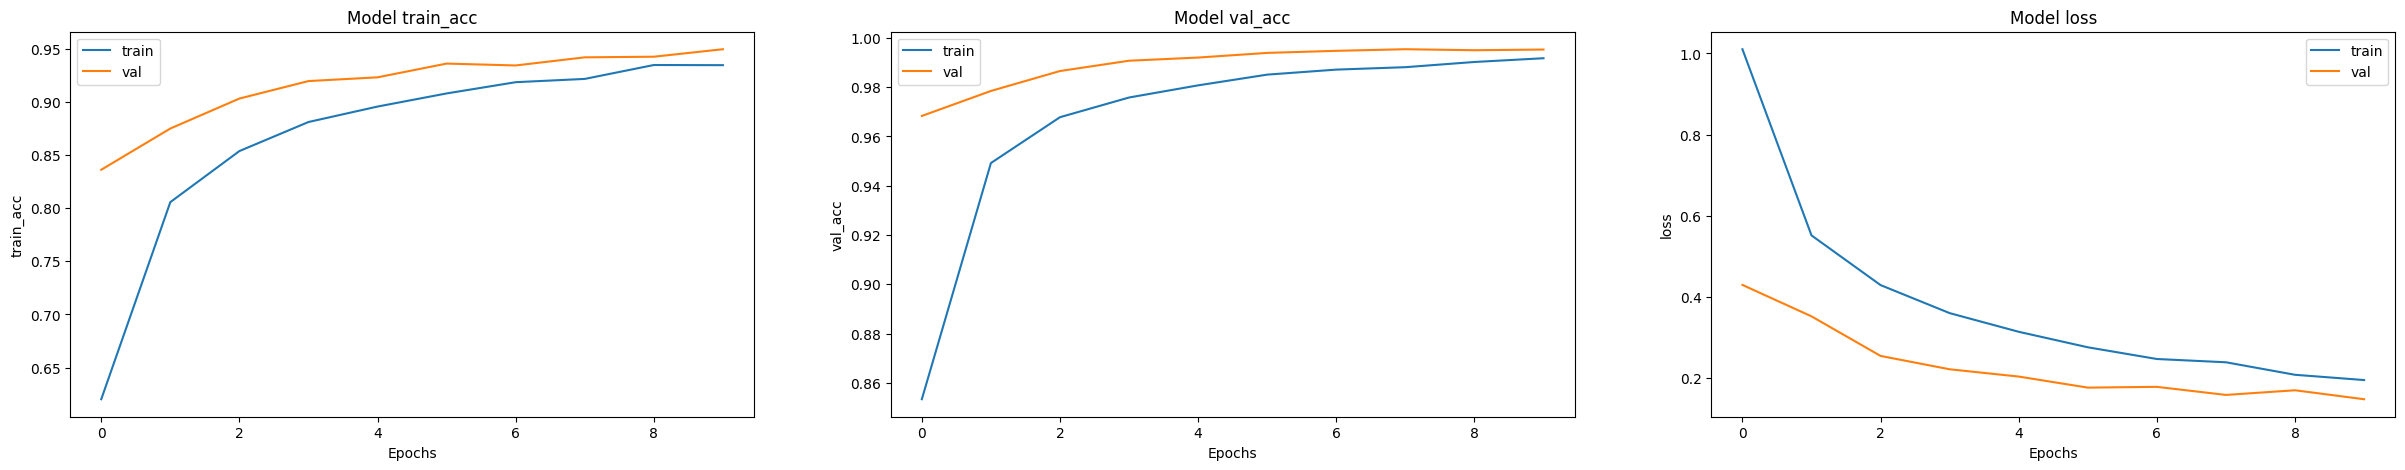

In [16]:
fig ,ax=plt.subplots(1,3,figsize=(30,5))
ax=ax.ravel()
for i,metric in enumerate(["train_acc","val_acc","loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_"+metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train","val"])

In [25]:
test_scores=custommodel.evaluate(test_data,test_labels)
print("Loss: ", test_scores[0])
print("Accuracy: ", test_scores[1])

67/67 [==============================] - 21s 305ms/step - loss: 0.1602 - train_acc: 0.9544 - val_acc: 0.9931 - f1_score: 0.9547
Loss:  0.1602264940738678
Accuracy:  0.9544172883033752


In [18]:
pred_labels=custommodel.predict(test_data)

67/67 [==============================] - 25s 357ms/step


In [19]:
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report,confusion_matrix

In [20]:
def roundoff(arr):
    arr[np.argwhere(arr!=arr.max())]=0
    arr[np.argwhere(arr==arr.max())]=1
    return arr
for labels in pred_labels:
    labels=roundoff(labels)
print(classification_report(test_labels,pred_labels,target_names=classes))

              precision    recall  f1-score   support

      glioma       0.99      0.90      0.94       521
  meningioma       0.91      0.95      0.93       567
     notumor       0.98      0.99      0.98       556
   pituitary       0.95      0.99      0.97       484

   micro avg       0.95      0.95      0.95      2128
   macro avg       0.96      0.95      0.95      2128
weighted avg       0.96      0.95      0.95      2128
 samples avg       0.95      0.95      0.95      2128



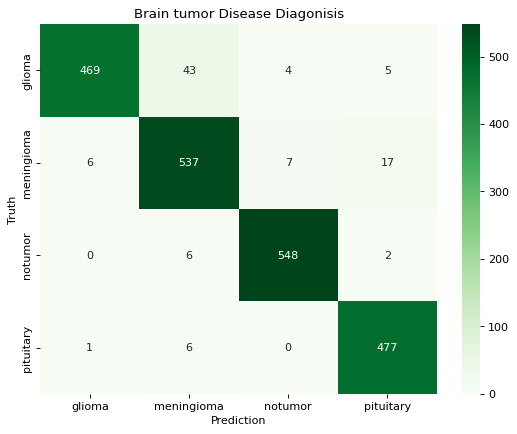

In [21]:
pred_ls=np.argmax(pred_labels,axis=1)
test_ls=np.argmax(test_labels,axis=1)
conf_arr=confusion_matrix(test_ls,pred_ls)
plt.figure(figsize=(8,6),dpi=80,facecolor='w',edgecolor='k')
ax=sns.heatmap(conf_arr,cmap='Greens',annot=True,fmt='d',xticklabels=classes,yticklabels=classes)
plt.title('Brain tumor Disease Diagonisis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

In [22]:
print('Balanced Accuracy score {}%'.format(round(BAS(test_ls,pred_ls)*100,2)))
print('Matthews Correleation Corrcoef {}%'.format(round(MCC(test_ls,pred_ls)*100,2)))

Balanced Accuracy score 95.46%
Matthews Correleation Corrcoef 93.95%


In [23]:
custom_incmodel_dir=wdr+"BT_CNN_model_inc_1"
custommodel.save(custom_incmodel_dir,save_format='h5')
os.listdir(wdr)

c:\Users\Jaswanth\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['BT_CNN_model_inc_1', 'glioma', 'meningioma', 'notumor', 'pituitary']

In [24]:
c=['MildDemented','ModerateDemented','NonDemented','VeryMildDemented']
ci=['glioma','meningioma','no-tumor','pituitary']
# Load the image
image = cv2.imread('./testim1.jpg')

# Resize the image to match the expected input shape
image = cv2.resize(image, (176, 176))

# Normalize the image
image = image / 255.0

# Add an extra dimension to the image
image = np.expand_dims(image, axis=0)

# Load the model
model = keras.models.load_model('./dataset4/BT_CNN_model_inc_1')

# Predict the class probabilities of the image
prediction = model.predict(image)

# Get the index of the class with the highest probability
pci = np.argmax(prediction[0])

# Display the result
print(prediction[0])
print('The predicted class is:', ci[pci])


1/1 [==============================] - 1s 862ms/step
[1.16479285e-04 7.66246521e-04 2.72896432e-05 9.99089956e-01]
The predicted class is: pituitary
